In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
class StateObj:
    def __init__(self):
        self.x = np.random.randint(0,1000)
        self.y = np.random.randint(0,1000)
        self.vx = np.random.randint(0,10)-5
        self.vy = np.random.randint(0,10)-5

    def set(self, x, y, vx, vy):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
    
    def __str__(self):
        return f"({self.x}, {self.y}, {self.vx}, {self.vy})"

    def __add__(self, other):
        new_state = StateObj()
        new_state.x = self.x + other.x
        new_state.y = self.y + other.y
        new_state.vx = self.vx + other.vx
        new_state.vy = self.vy + other.vy
        return new_state

    def np(self):
        return np.array([[self.x, self.y, self.vx, self.vy]]).T

# Simulation

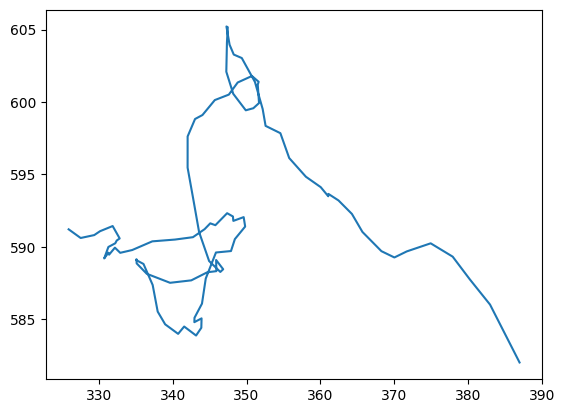

In [117]:
true_state = StateObj() # state vector (position, velocity)
position_variance = 1 # measurement variance
velocity_variance = 0.0001
dt = 1

true_position_x = [true_state.x]
true_position_y = [true_state.y]
true_velocity_x = [true_state.vx]
true_velocity_y = [true_state.vy]

for _ in range(100):

    true_state.x = true_state.x + dt*true_state.vx
    true_state.y = true_state.y + dt*true_state.vy
    true_state.vx = 0.75*true_state.vx + 0.25*(np.random.randint(0, 10)-5)
    true_state.vy = 0.75*true_state.vy + 0.25*(np.random.randint(0, 10)-5)

    true_position_x.append(true_state.x)
    true_position_y.append(true_state.y)
    true_velocity_x.append(true_state.vx)
    true_velocity_y.append(true_state.vy)

plt.plot(true_position_x, true_position_y, label='true position')

def measure(idx: int) -> StateObj:
    _state = StateObj()
    _state.x = true_position_x[idx] + np.random.normal(0, position_variance)
    _state.y = true_position_y[idx] + np.random.normal(0, position_variance)
    _state.vx = true_velocity_x[idx] + np.random.normal(0, velocity_variance)
    _state.vy = true_velocity_y[idx] + np.random.normal(0, velocity_variance)
    return _state

In [122]:
def predict_state(current_state: StateObj, state_transition: np.array) -> np.array:
    ps = state_transition @ current_state.np()
    predicted_state = StateObj()
    predicted_state.set(ps[0][0], ps[1][0], ps[2][0], ps[3][0])
    return predicted_state

def predict_covariance(covariance: np.array, process_covariance: np.array, state_transition: np.array) -> np.array:
    if covariance.size == 0:
        covariance = process_covariance
    predicted_covariance = state_transition @ covariance @ state_transition.T + process_covariance
    return predicted_covariance

def kalman_filter(predicted_state: StateObj, covariance: np.array, observation: np.array, measured_state: StateObj, measurement_covariance: float):
    # kalman gain
    K = covariance @ observation.T @ np.linalg.inv(observation @ covariance @ observation.T + measurement_covariance)

    # kalman update
    new_state = StateObj()
    s_t = predicted_state.np() + K @ (observation @ measured_state.np() - observation @ predicted_state.np())
    new_state.set(s_t[0][0], s_t[1][0], s_t[2][0], s_t[3][0])

    covariance = (np.eye(4) - K @ observation) @ covariance

    return new_state, covariance

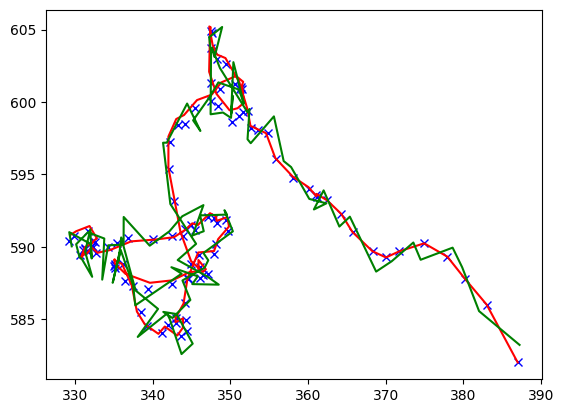

In [123]:
dt = 1 # time step
state = StateObj()   # initial state
state.set(true_position_x[0], true_position_y[0], true_velocity_x[0], true_velocity_y[0])


state_transition = np.array([[1, 0, dt, 0],
                             [0, 1, 0, dt],
                             [0, 0, 1, 0 ],
                             [0, 0, 0, 1 ]])

input_transition = np.array([[0],
                             [0],
                             [0],
                             [0]])

measurement_variance = position_variance # measurement variance
measurement_covariance = measurement_variance * np.eye(2)

process_variance = velocity_variance # process variance
process_covariance = process_variance * dt * np.eye(4)

covariance = np.array([[]]) # covariance matrix
observation = np.array([[1, 0, 0, 0],
                        [0, 1, 0, 0]]) # observation matrix


tracked_position_x = [state.x]
tracked_position_y = [state.y]

measured_state = measure(0)
measured_position_x = [measured_state.x]
measured_position_y = [measured_state.y]

N = 99
for idx in range(0, N):

    state.vx = measured_state.vx
    state.vy = measured_state.vy

    state = predict_state(state, state_transition)
    
    covariance = predict_covariance(covariance, process_covariance, state_transition)

    # measurements
    measured_state = measure(idx+1)

    state, covariance = kalman_filter(state, covariance, observation, measured_state, measurement_covariance)

    tracked_position_x.append(state.x)
    tracked_position_y.append(state.y)

    measured_position_x.append(measured_state.x)
    measured_position_y.append(measured_state.y)

plt.plot(tracked_position_x[0:N], tracked_position_y[0:N], 'bx')
plt.plot(true_position_x[0:N], true_position_y[0:N], 'r')
plt.plot(measured_position_x[0:N], measured_position_y[0:N], 'g')
